In [1]:
import numpy as np
import librosa
import librosa.display
import soundfile
from matplotlib import pyplot as plt
from PIL import Image as im
import os
from librosa.feature import melspectrogram
from tqdm import tqdm

In [2]:
# O objetivo das funções abaixo é tornar viável a conversão dos 
# nossos espectrogramas em imagens que podem ser lidas com o mínimo 
# de perda de informação possível

def map_values(x, leftMin, leftMax, rightMin, rightMax):
    return rightMin + ((x - leftMin) / (leftMax - leftMin) * (rightMax - rightMin))

def unmap_values(y, leftMin, leftMax, rightMin, rightMax):
    return (y * (leftMin - leftMax) + leftMax * rightMin - leftMin * rightMax) / (rightMin - rightMax)

def amp_to_log(x, vmin = 0.001, leftMin=0, leftMax=233.95848, rightMin=0, rightMax=255):
    leftMin = np.log10(np.abs(leftMin) + vmin)
    leftMax = np.log10(np.abs(leftMax) + vmin)
    return map_values(np.log10(np.abs(x) + vmin), leftMin, leftMax, rightMin, rightMax)

def log_to_amp(x, vmin = 0.001, leftMin=0, leftMax=233.95848, rightMin=0, rightMax=255):
    leftMin = np.log10(np.abs(leftMin) + vmin)
    leftMax = np.log10(np.abs(leftMax) + vmin)
    return 10 ** unmap_values(x, leftMin, leftMax, rightMin, rightMax) - vmin

In [16]:
# Verifica os ranges de transformação

# x_t = list()
# x_db = list()
# for audio in tqdm(os.listdir("./audios")):
#     x, sr = librosa.load(f"./audios/{audio}", offset=0, duration=20)
#     x_transformed = librosa.stft(x)
#     x_t.append(x_transformed)
#     xdb = np.log10(np.abs(x_transformed) + 0.001)
#     x_db.append(xdb)
# x_t = np.array(x_t)
# x_db = np.array(x_db)

# print(np.abs(x_t).min())
# print(np.abs(x_t).max())
# print(x_db.min())
# print(x_db.max())

# print(np.log10(np.abs(0) + 0.001))
# print(np.log10(np.abs(233.95848) + 0.001))

# print(amp_to_log(np.abs(x_t).min()))
# print(amp_to_log(np.abs(x_t).max()))

# print(log_to_amp(amp_to_log(np.abs(x_t).min())))
# print(log_to_amp(amp_to_log(np.abs(x_t).max())))

# Ranges já verificados e inseridos nos seus lugares adequados

## Bruno, leia aqui
#### Identifiquei o nosso maior problema e a maior fonte de perda. A transformada stft gera um resultado com seus parâmetros padrões que não são adequados para o nosso caso. O próximo passo é estudar como funcionam as entradas da função stft e fazer ela gerar como saída arrays que tenham exatamente o shape (img_size x img_size) para podermos reduzir ao máximo a perda de informação nesse passo.

c:\users\ramon\anaconda3\envs\spectrogan\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(441000,)
(1025, 862)
(1025, 862)
before


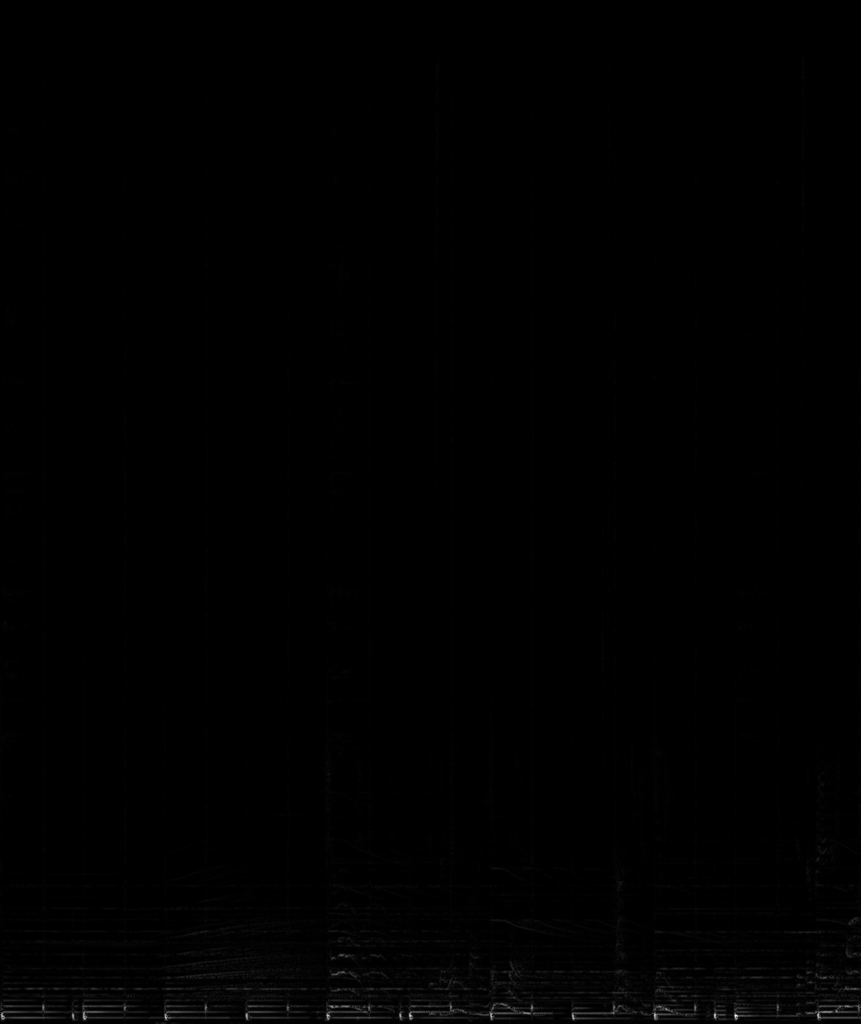

after


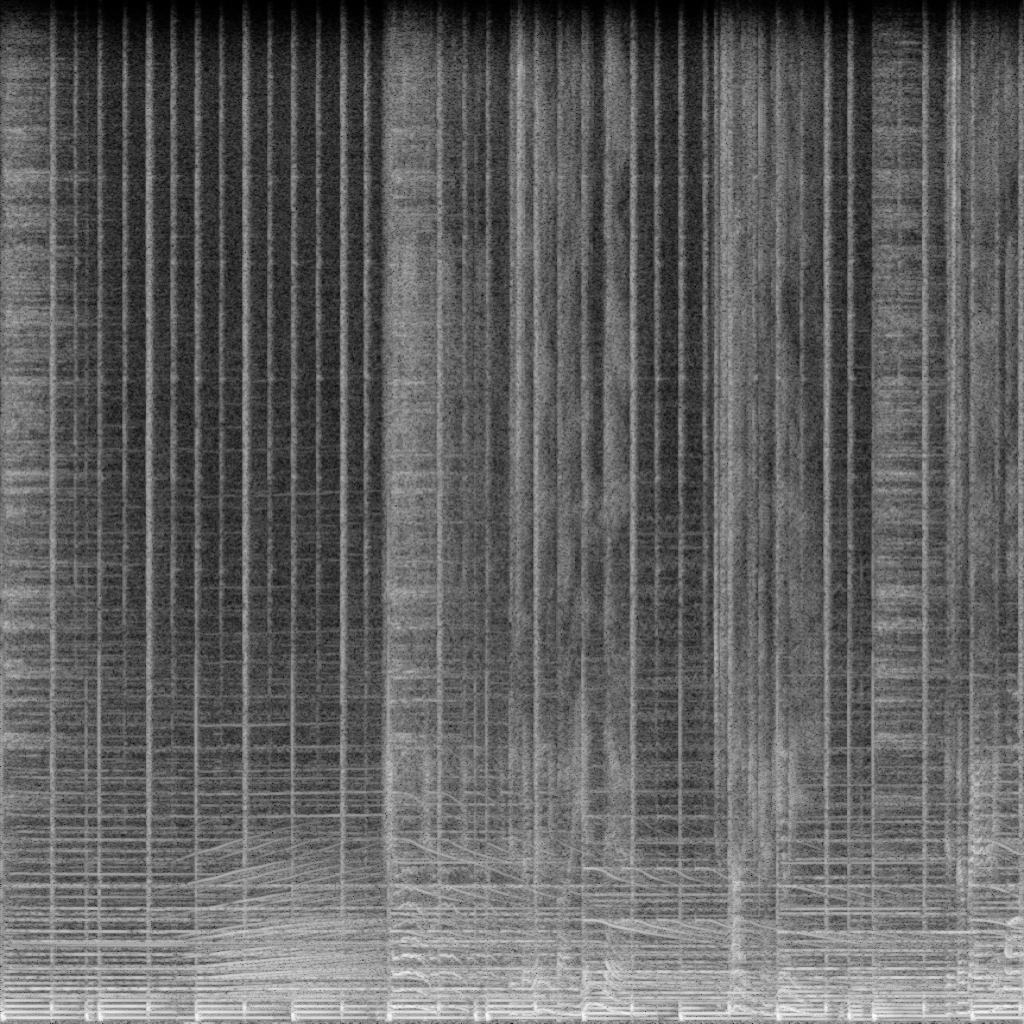

reversed


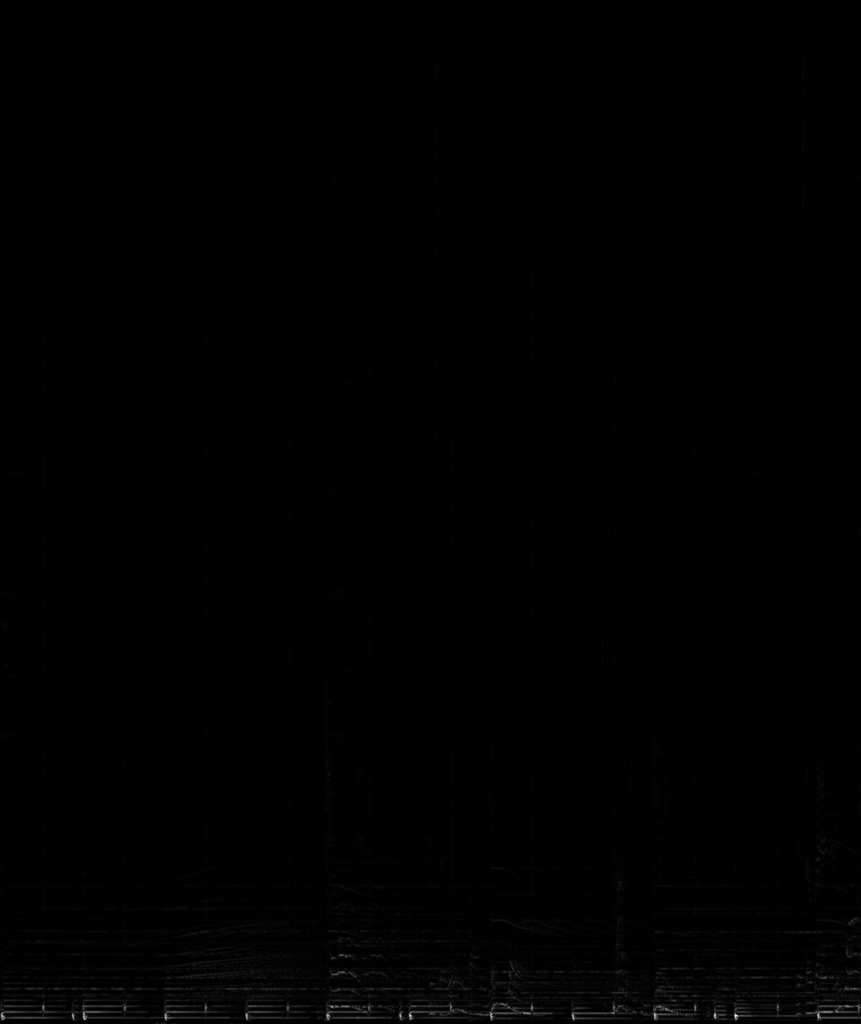

In [4]:
img_size = 1024
x, sr = librosa.load("./audios/ComfortablyNumb.mp3", offset=0, duration=20)
print("Shape do array lido diretamente do áudio: ", x.shape)
soundfile.write("./from_spectrogram/teste_salvar_o_que_leu.wav", x, sr)
x_transformed = np.flip(librosa.stft(x), axis=0)
print("Shape do áudio convertido pelo stft com os parâmetros default: ", x_transformed.shape)
soundfile.write("./from_spectrogram/teste_stft.wav", librosa.griffinlim(np.abs(x_transformed)), sr)
xdb = np.round(amp_to_log(x_transformed)).astype(int)
print("Shape do espectrograma após passar pela conversão logarítmica e escala (Tem que ser o memso do stft)", xdb.shape)
fig = plt.figure(figsize=(img_size, img_size), dpi=1, frameon=False)
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.axis('off')
print("before")
img = plt.imshow(np.abs(x_transformed), cmap='gray')
plt.show()
librosa.cache.clear()
plt.close()

fig = plt.figure(figsize=(img_size, img_size), dpi=1, frameon=False)
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.axis('off')
fig.add_axes(ax)
print("after")
ax.imshow(xdb, cmap='gray', aspect='auto')
plt.savefig("./from_spectrogram/teste.tiff", dpi=1, pil_kwargs={"quality":100})
plt.show()
librosa.cache.clear()

xdb_reversed = log_to_amp(xdb)
soundfile.write("./from_spectrogram/teste_reversed.wav", librosa.griffinlim(np.abs(xdb_reversed)), sr)
print("reversed")
fig = plt.figure(figsize=(img_size, img_size), dpi=1, frameon=False)
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.axis('off')
img = plt.imshow(xdb_reversed, cmap='gray')
plt.show()
librosa.cache.clear()

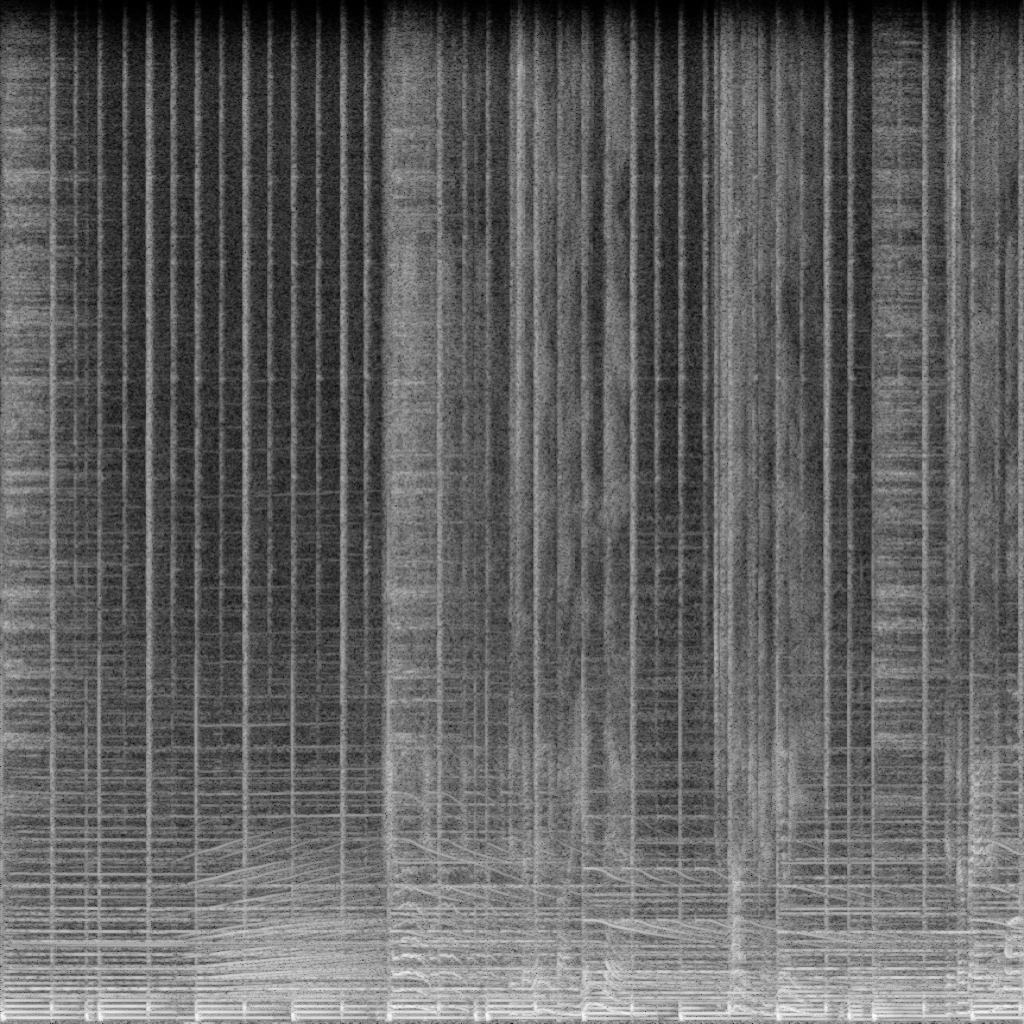

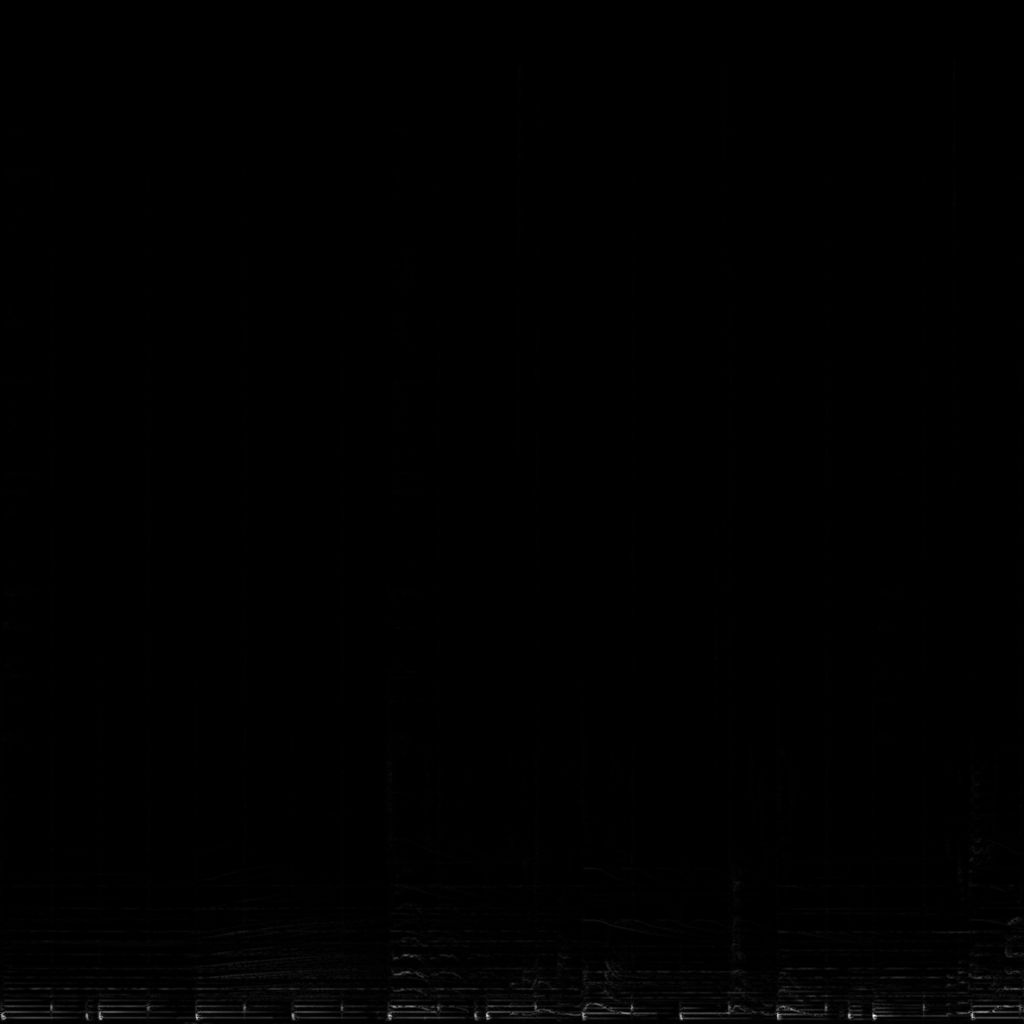

In [6]:
img = plt.imread("./from_spectrogram/teste.tiff")
img = img[:,:,0]
img_amp = log_to_amp(img)

fig = plt.figure(figsize=(img_size, img_size), dpi=1, frameon=False)
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.axis('off')
plt.imshow(img, cmap="gray")
plt.show()

fig = plt.figure(figsize=(img_size, img_size), dpi=1, frameon=False)
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.axis('off')
plt.imshow(img_amp, cmap="gray")
plt.show()

result = librosa.griffinlim(np.abs(img_amp))
soundfile.write("./from_spectrogram/teste_read_from_file.wav", result, sr)

Testes do que acontece ao salvar imagens com diferentes intervalos

In [9]:
# teste_img = np.array([[0, 144, 232], [5, 267, 1322], [123, 1333, 22]])
# plt.imsave("./from_spectrogram/testemais255.tiff", teste_img, cmap="gray")

In [10]:
# teste_img_read = plt.imread("./from_spectrogram/testemais255.tiff")

In [11]:
# teste_img

In [12]:
# teste_img_read[:,:,0]

In [13]:
# teste_img = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
# plt.imsave("./from_spectrogram/testemais255.tiff", teste_img, cmap="gray")
# teste_img_read = plt.imread("./from_spectrogram/testemais255.tiff")

In [14]:
# teste_img

In [15]:
# teste_img_read[:,:,0]

Conclusão, os valores são sempre escalados para o intervalo de 0 a 255, em todos os casos

Ou seja, se a imagem for:

[0, 1], [1, 0]

Ela vira

[0, 255], [255, 0]

E se ela for

[1000, 10000], [10000, 1000]

Ela vira

[0, 255], [255, 0]